# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Load the Dataset

In [2]:
df = pd.read_excel("job_market_raw_data.xlsx")

df.head()

,job_id,job_title,company_name,location,experience_required,salary_min,salary_max,skills,job_type,posted_date,source
0,1,Business Data Analyst,TCS,Hyderabad,0,320858,455301,"Python, SQL, Statistics",Full-time,2026-01-24,Naukri
1,2,Business Data Analyst,Wipro,Bangalore,2,750065,918643,"Python, SQL, Excel",Full-time,2026-01-30,Indeed
2,3,Junior Data Analyst,Infosys,Hyderabad,3,755194,1038732,"SQL, Excel",Internship,2026-01-19,LinkedIn
3,4,Business Data Analyst,TCS,Mumbai,3,832970,955172,"Python, SQL, Statistics",Internship,2025-12-11,Naukri
4,5,Data Analyst,Wipro,Pune,1,432254,652359,"Python, SQL, Machine Learning",Internship,2026-01-13,Indeed


# Basic Data Preparation (for statistics)

# Create avg_salary

In [3]:
df['avg_salary'] = (df['salary_min'] + df['salary_max']) / 2

# Handle missing values

In [4]:
df = df.dropna(subset=['avg_salary', 'experience_required'])

# Descriptive Statistics

In [5]:
df['avg_salary'].describe()

count    5.000000e+02
mean     6.817842e+05
std      1.741105e+05
min      3.615770e+05
25%      5.253960e+05
50%      6.860545e+05
75%      8.207406e+05
max      1.047719e+06
Name: avg_salary, dtype: float64

# Additional metrics

In [6]:
mean_salary = df['avg_salary'].mean()
median_salary = df['avg_salary'].median()
std_salary = df['avg_salary'].std()

mean_salary, median_salary, std_salary

(681784.159, 686054.5, 174110.48093186377)

# Salary Distribution Visualization

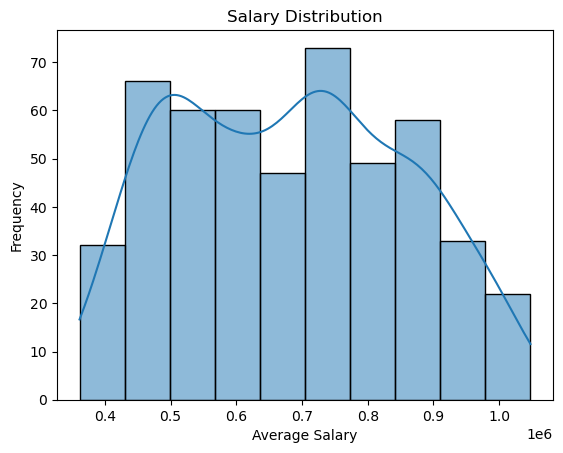

In [7]:
plt.figure()
sns.histplot(df['avg_salary'], kde=True)
plt.title("Salary Distribution")
plt.xlabel("Average Salary")
plt.ylabel("Frequency")
plt.show()

# Hypothesis Testing – Python Skill vs Salary

# Create Python-skill flag

In [8]:
df['has_python'] = df['skills'].str.contains('Python', case=False)

# Split salary groups

In [9]:
salary_python = df[df['has_python']]['avg_salary']
salary_no_python = df[~df['has_python']]['avg_salary']

# Independent T-Test

In [10]:
t_stat, p_value = stats.ttest_ind(salary_python, salary_no_python, equal_var=False)

t_stat, p_value

(0.47324726283177737, 0.6363009339021326)

# Experience vs Salary (ANOVA)

In [11]:
anova_result = stats.f_oneway(
    df[df['experience_required'] == 0]['avg_salary'],
    df[df['experience_required'] == 1]['avg_salary'],
    df[df['experience_required'] == 2]['avg_salary'],
    df[df['experience_required'] >= 3]['avg_salary']
)

anova_result

F_onewayResult(statistic=402.73280100016126, pvalue=1.7316531870765135e-132)

# Correlation Analysis

In [12]:
df[['experience_required', 'avg_salary']].corr()

,experience_required,avg_salary
experience_required,1.000000,0.754569
avg_salary,0.754569,1.000000


# Visualization

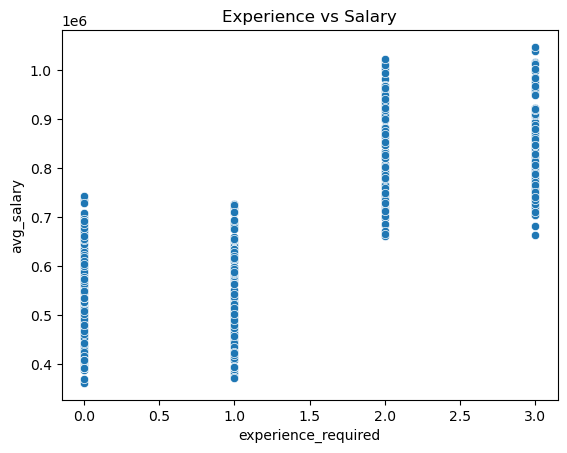

In [13]:
plt.figure()
sns.scatterplot(x='experience_required', y='avg_salary', data=df)
plt.title("Experience vs Salary")
plt.show()

# City Type Analysis (Metro vs Non-Metro)

In [14]:
metro_cities = ['Bangalore', 'Mumbai', 'Delhi', 'Hyderabad', 'Chennai']

df['city_type'] = df['location'].apply(
    lambda x: 'Metro' if x in metro_cities else 'Non-Metro'
)

# Mann–Whitney U Test

In [15]:
metro_salary = df[df['city_type'] == 'Metro']['avg_salary']
non_metro_salary = df[df['city_type'] == 'Non-Metro']['avg_salary']

stats.mannwhitneyu(metro_salary, non_metro_salary)

MannwhitneyuResult(statistic=16241.0, pvalue=0.12519196441238464)

# DATABASE & TABLE CREATION

# 1️⃣ Create Database

In [18]:
import sqlite3
import pandas as pd

In [19]:
# Create SQLite database
conn = sqlite3.connect("job_market.db")

# Push Your DataFrame into SQL Table

In [20]:
df.to_sql("job_market", conn, if_exists="replace", index=False)

500

# How to Write SQL Queries in Jupyter

# Using pandas + SQL

In [21]:
query = """
SELECT * FROM job_market
LIMIT 5;
"""

pd.read_sql(query, conn)

,job_id,job_title,company_name,location,experience_required,salary_min,salary_max,skills,job_type,posted_date,source,avg_salary,has_python,city_type
0,1,Business Data Analyst,TCS,Hyderabad,0,320858,455301,"Python, SQL, Statistics",Full-time,2026-01-24 00:00:00,Naukri,388079.5,1,Metro
1,2,Business Data Analyst,Wipro,Bangalore,2,750065,918643,"Python, SQL, Excel",Full-time,2026-01-30 00:00:00,Indeed,834354.0,1,Metro
2,3,Junior Data Analyst,Infosys,Hyderabad,3,755194,1038732,"SQL, Excel",Internship,2026-01-19 00:00:00,LinkedIn,896963.0,0,Metro
3,4,Business Data Analyst,TCS,Mumbai,3,832970,955172,"Python, SQL, Statistics",Internship,2025-12-11 00:00:00,Naukri,894071.0,1,Metro
4,5,Data Analyst,Wipro,Pune,1,432254,652359,"Python, SQL, Machine Learning",Internship,2026-01-13 00:00:00,Indeed,542306.5,1,Non-Metro


# Resume-Level SQL Queries

# 1️⃣ Average Salary by Job Role

In [23]:
query = """
SELECT job_title,
       ROUND(AVG(avg_salary), 2) AS avg_salary
FROM job_market
GROUP BY job_title
ORDER BY avg_salary DESC;
"""

pd.read_sql(query, conn)

,job_title,avg_salary
0,Junior Data Analyst,692232.08
1,Business Data Analyst,682681.08
2,Data Analyst,671550.25


# 2️⃣ Salary Comparison: Metro vs Non-Metro

In [25]:
query = """
SELECT city_type,
       AVG(avg_salary) AS avg_salary
FROM job_market
GROUP BY city_type;
"""

pd.read_sql(query, conn)

,city_type,avg_salary
0,Metro,675846.786408
1,Non-Metro,709581.857955


# 3️⃣ Experience vs Salary

In [26]:
query = """
SELECT experience_required,
       AVG(avg_salary) AS avg_salary
FROM job_market
GROUP BY experience_required
ORDER BY experience_required;
"""

pd.read_sql(query, conn)

,experience_required,avg_salary
0,0,541488.305755
1,1,547763.161417
2,2,843741.853211
3,3,832731.372000


# 4️⃣ Top Paying Locations

In [27]:
query = """
SELECT location,
       AVG(avg_salary) AS avg_salary
FROM job_market
GROUP BY location
ORDER BY avg_salary DESC
LIMIT 10;
"""

pd.read_sql(query, conn)

,location,avg_salary
0,Pune,709581.857955
1,Chennai,699590.652439
2,Bangalore,683247.657895
3,Delhi,672897.778947
4,Hyderabad,672096.430556
5,Mumbai,653326.304598


# 5️⃣ High Demand Skills

In [28]:
query = """
SELECT skills,
       COUNT(*) AS demand_count
FROM job_market
GROUP BY skills
ORDER BY demand_count DESC;
"""

pd.read_sql(query, conn)

,skills,demand_count
0,"Python, SQL, Statistics",114
1,"Python, SQL, Excel",105
2,"Python, SQL, Machine Learning",102
3,"Excel, SQL, Power BI",98
4,"SQL, Excel",81


# Close the SQL Connection

In [29]:
conn.close()

# DATA VISUALIZATION IN PYTHON

# 1️⃣ Salary Distribution (Market Overview)

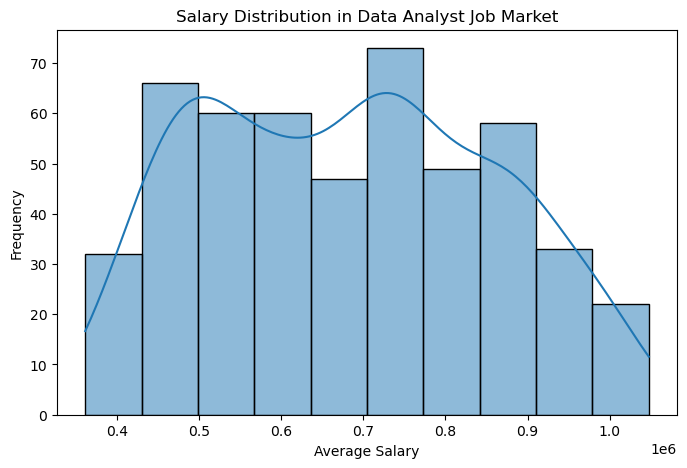

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(df['avg_salary'], kde=True)
plt.title("Salary Distribution in Data Analyst Job Market")
plt.xlabel("Average Salary")
plt.ylabel("Frequency")
plt.show()

# 2️⃣ Experience vs Salary

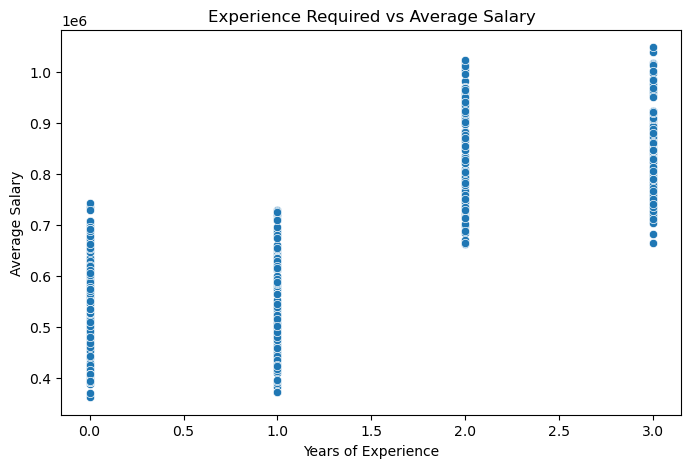

In [31]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='experience_required', y='avg_salary', data=df)
plt.title("Experience Required vs Average Salary")
plt.xlabel("Years of Experience")
plt.ylabel("Average Salary")
plt.show()

# 3️⃣ Metro vs Non-Metro Salary Comparison

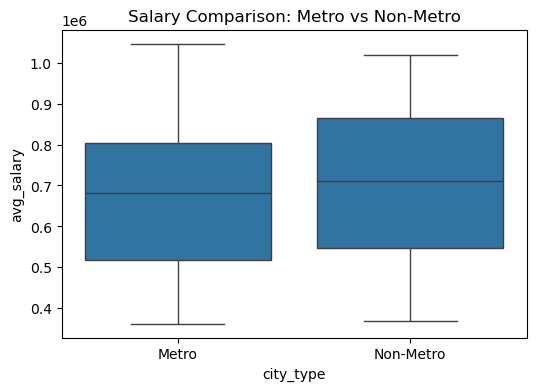

In [32]:
plt.figure(figsize=(6,4))
sns.boxplot(x='city_type', y='avg_salary', data=df)
plt.title("Salary Comparison: Metro vs Non-Metro")
plt.show()

# 4️⃣ Top Skills Demand

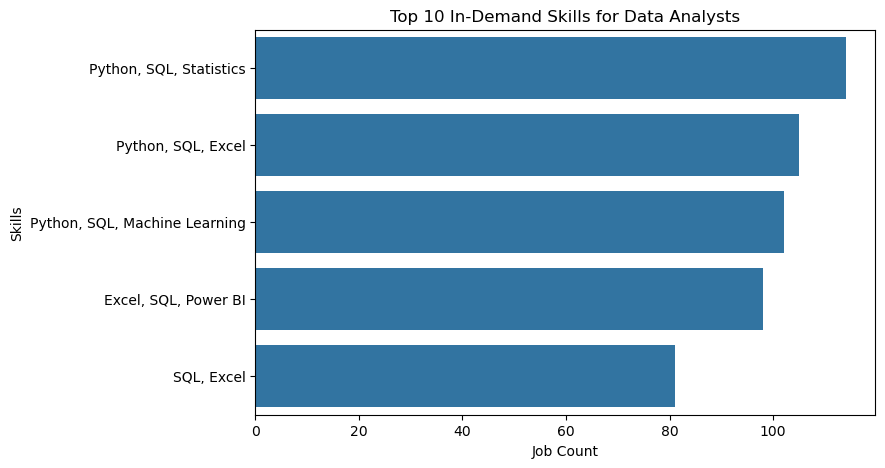

In [33]:
skills_count = df['skills'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=skills_count.values, y=skills_count.index)
plt.title("Top 10 In-Demand Skills for Data Analysts")
plt.xlabel("Job Count")
plt.ylabel("Skills")
plt.show()

# Prepare Data for AI

# 1️⃣ Select Required Columns

In [34]:
features = df[['experience_required', 'city_type', 'skills']]
target = df['avg_salary']

# 2️⃣ Encode Categorical Data

In [35]:
from sklearn.preprocessing import LabelEncoder

le_city = LabelEncoder()
df['city_encoded'] = le_city.fit_transform(df['city_type'])

le_skill = LabelEncoder()
df['skills_encoded'] = le_skill.fit_transform(df['skills'])

In [36]:
X = df[['experience_required', 'city_encoded', 'skills_encoded']]
y = df['avg_salary']

# Train Test Split

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build AI Model (Regression)

In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Evaluate AI Model

In [39]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

(77587.34722718572, 0.7199697655809995)

# Feature Importance

In [40]:
importance = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,experience_required,0.950822
2,skills_encoded,0.033633
1,city_encoded,0.015545


# 📊 Visualize Feature Importance

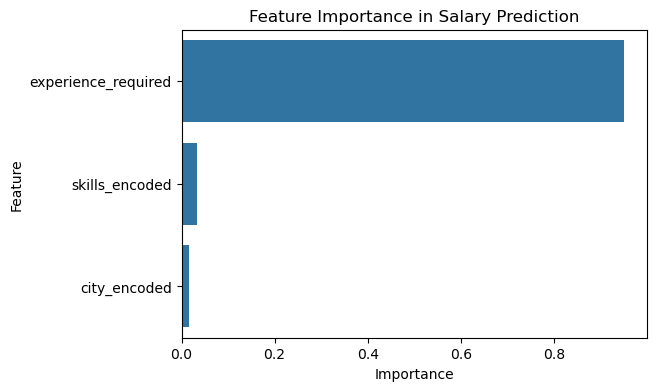

In [41]:
plt.figure(figsize=(6,4))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df
)
plt.title("Feature Importance in Salary Prediction")
plt.show()

# Make Salary Prediction (REAL USE CASE)

In [42]:
# Example: 2 years experience, Metro city, Python skill
sample_input = [[2, 1, 3]]   # encoded values

predicted_salary = model.predict(sample_input)
predicted_salary

C:\Users\ADMIN\anaconda3\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([815524.19796821])

# Select Features & Target (FINAL AI DATA)

In [43]:
X = df[['experience_required', 'city_encoded', 'skills_encoded']]
y = df['avg_salary']

# Final Verification

In [44]:
print(X.head())
print(y.head())
print(X.shape, y.shape)

   experience_required  city_encoded  skills_encoded
0                    0             0               3
1                    2             0               1
2                    3             0               4
3                    3             0               3
4                    1             1               2
0    388079.5
1    834354.0
2    896963.0
3    894071.0
4    542306.5
Name: avg_salary, dtype: float64
(500, 3) (500,)
